## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True)
times = np.load('/home/paul/Bureau/IRAP/TablesAU_MIC/readyforwPCA_epoc.npy')

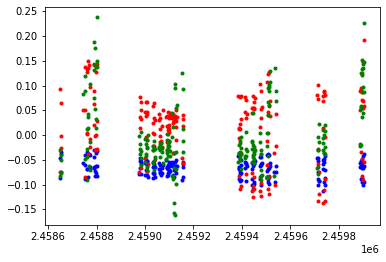

In [209]:
plt.plot(times[:-1], eigen2vectors[0], 'b.')
plt.plot(times[:-1], eigen2vectors[1], 'r.')
plt.plot(times[:-1], eigen2vectors[2], 'g.')
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872250163692226


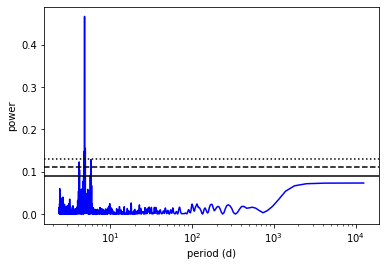

In [162]:
frequency, power = LombScargle(times[:-1], eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 2nd component

Peak frequency = 
4.872250163692226


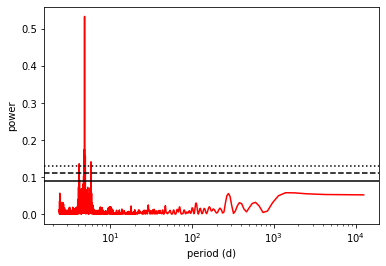

In [210]:
frequency, power = LombScargle(times[:-1], eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### 3rd component

Peak frequency = 
359.01523349035


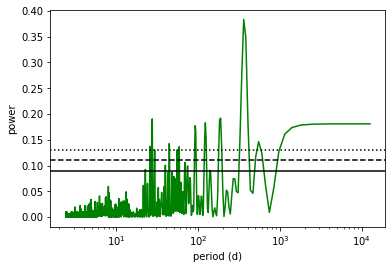

In [164]:
frequency, power = LombScargle(times[:-1], eigen2vectors[2]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times[:-1], eigen2vectors[2])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [196]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))


0.1668876987460044
0.016793872222717703
12565.53317216225


In [197]:
#Priors
n_eta1 = ModifiedLogUniform(0.016, 0.16)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.016, 0.16)

In [198]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [199]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [200]:
ndim = priors().size 
nwalkers = 2*ndim

In [201]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:11<00:00, 23.19it/s]


State([[1.58592867e-02 1.08116026e+02 4.86501082e+00 7.69583728e-01
  4.29895111e-03]
 [1.59504141e-02 2.04971266e+02 4.86089770e+00 5.47732471e-01
  4.62960004e-03]
 [2.01311365e-02 1.92877587e+02 4.86538183e+00 7.37090677e-01
  4.16057855e-03]
 [1.53990124e-02 1.44418516e+02 4.86313046e+00 9.02700155e-01
  4.28161539e-03]
 [1.61079890e-02 1.69993042e+02 4.86585659e+00 8.83153127e-01
  5.00747835e-03]
 [1.70280285e-02 1.46093134e+02 4.86580426e+00 8.51217355e-01
  4.04682333e-03]
 [1.98190489e-02 1.30971153e+02 4.86729622e+00 1.03259876e+00
  4.27746104e-03]
 [1.46480058e-02 1.44665920e+02 4.85872398e+00 8.49046326e-01
  4.36479672e-03]
 [1.93043769e-02 1.67614968e+02 4.86150260e+00 7.30899069e-01
  4.58572542e-03]
 [1.38147856e-02 1.14328216e+02 4.86304568e+00 5.90212158e-01
  4.12222323e-03]], log_prob=[741.30382136 740.40627237 736.02869342 741.76399779 740.42388502
 739.94094389 739.85879558 742.24431433 741.50142226 739.27563741], blobs=None, random_state=('MT19937', array([32978

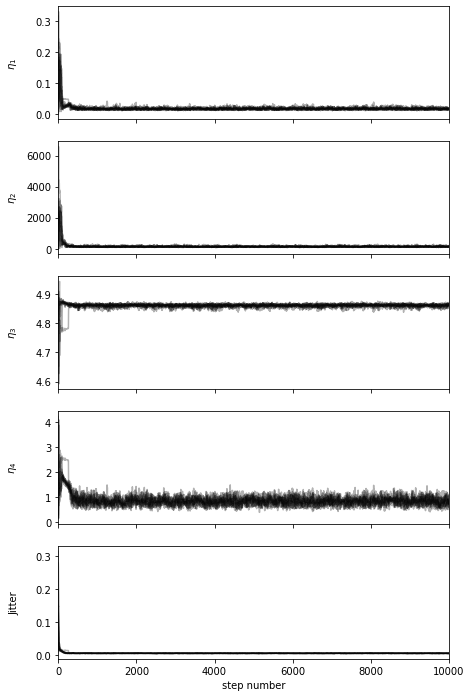

In [202]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

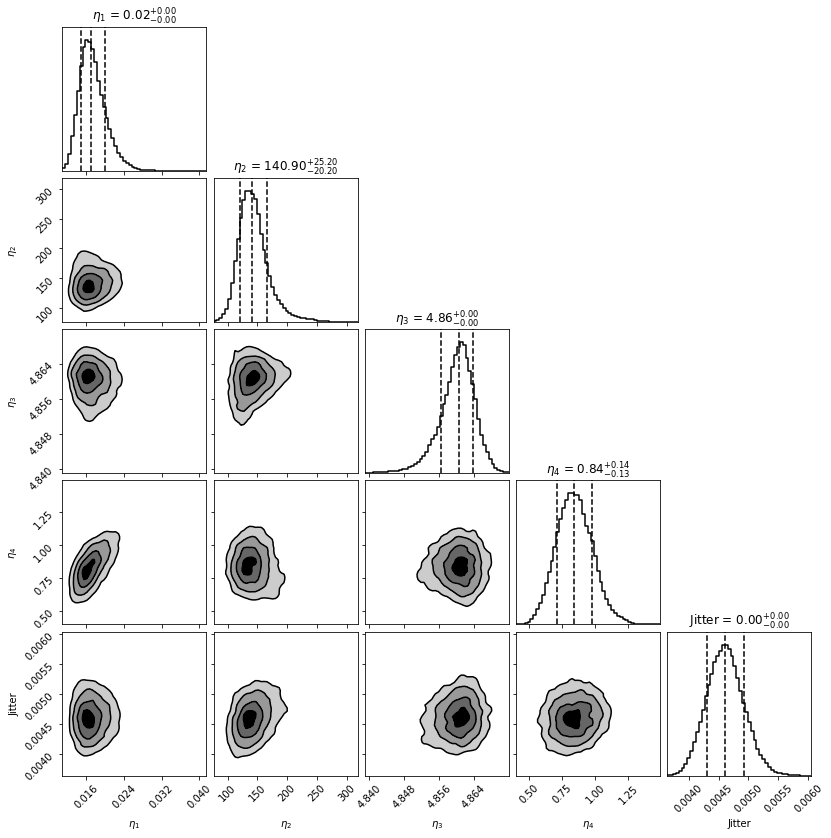

In [203]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [204]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[0],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

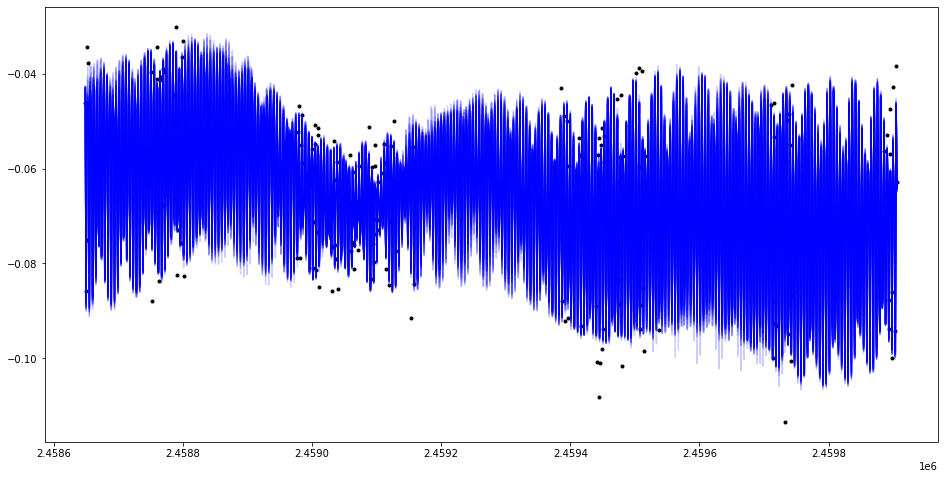

In [205]:
plt.figure(figsize=(16, 8))

plt.plot(times[:-1], eigen2vectors[0],'k.')
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

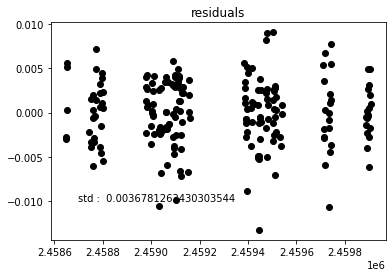

In [206]:
y_sample = Display(flat_samples[0,:], times[:-1])

residuals = eigen2vectors[0] - y_sample

plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.01) )
plt.title('residuals')
plt.show()

## 2nd component GP

In [185]:
print(2*(np.max(eigen2vectors[1])- np.min(eigen2vectors[1])))
print(np.std(eigen2vectors[1]))
print(10*(np.max(times[:-1])-np.min(times[:-1])))

0.6569246234698661
0.06718304428248568
12565.53317216225


In [186]:
#Priors
n_eta1 = ModifiedLogUniform(0.06, 0.65)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.06, 0.65)

In [187]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [188]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1], yerr = 1e-12 * np.identity(times[:-1].size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [189]:
ndim = priors().size 
nwalkers = 2*ndim

In [190]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [07:05<00:00, 23.52it/s]


State([[5.92160202e-02 1.23492152e+02 4.86251686e+00 8.72826577e-01
  9.60575196e-03]
 [8.30992574e-02 1.71971778e+02 4.86176353e+00 1.02143499e+00
  9.74274332e-03]
 [6.93448328e-02 1.82485457e+02 4.85848584e+00 6.66435876e-01
  9.12066665e-03]
 [5.94080758e-02 1.32694246e+02 4.86578110e+00 8.40285955e-01
  1.01690030e-02]
 [6.26916689e-02 1.38752050e+02 4.85727917e+00 8.60799354e-01
  9.01746037e-03]
 [7.76477045e-02 1.48940019e+02 4.86191829e+00 1.06490131e+00
  1.08737536e-02]
 [6.32257729e-02 1.20358792e+02 4.85630171e+00 6.92468710e-01
  8.46637821e-03]
 [7.61060624e-02 1.23677882e+02 4.86592868e+00 9.43507500e-01
  8.92918726e-03]
 [6.94677620e-02 1.47794813e+02 4.85932103e+00 8.43108693e-01
  9.47257197e-03]
 [5.85330362e-02 1.17012192e+02 4.86114275e+00 9.62079336e-01
  1.01457229e-02]], log_prob=[549.88572718 546.84787601 542.25717536 548.25971391 549.80243689
 546.64089851 545.81807191 547.67332517 550.29452768 546.68539691], blobs=None, random_state=('MT19937', array([32978

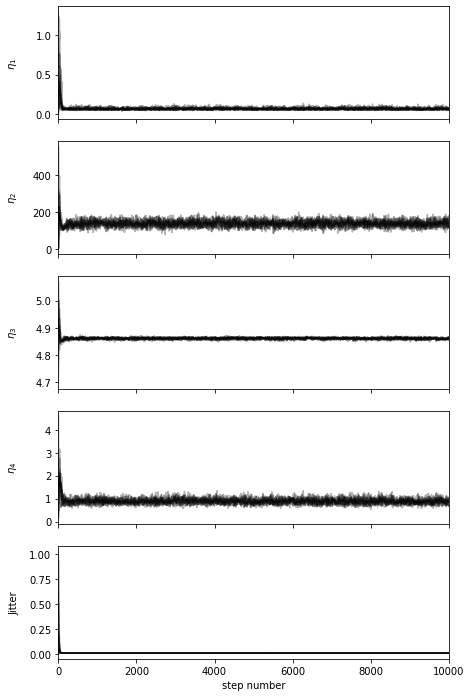

In [191]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

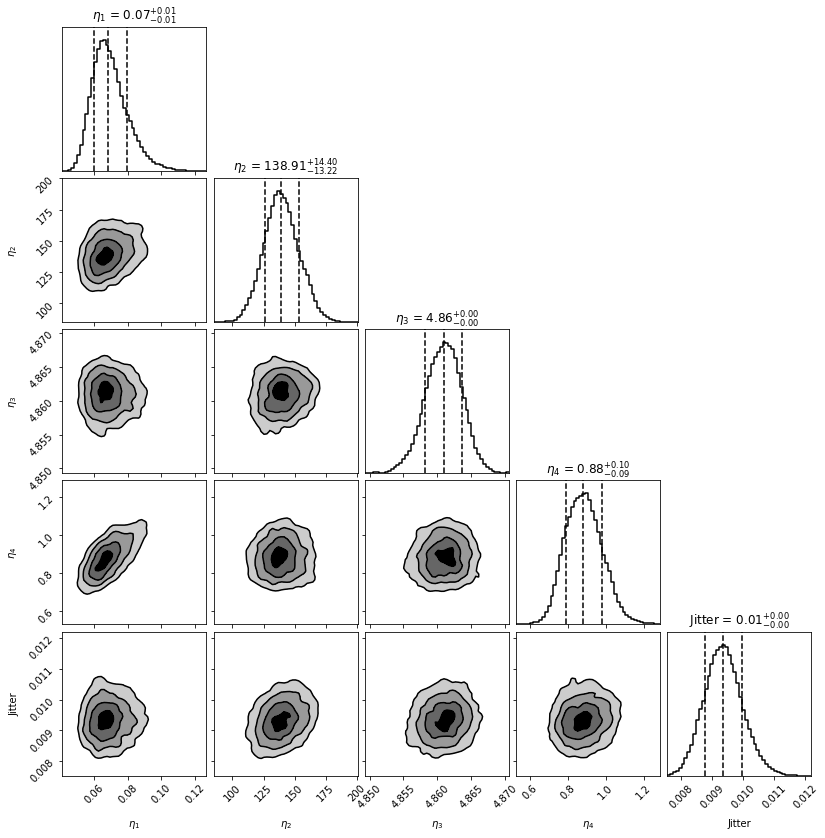

In [192]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False)
plt.show()

In [193]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[1]))
    gpOBJ = process.GP(kernel,mean,times[:-1],eigen2vectors[1],yerr = 1e-12 * np.identity(times[:-1].size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

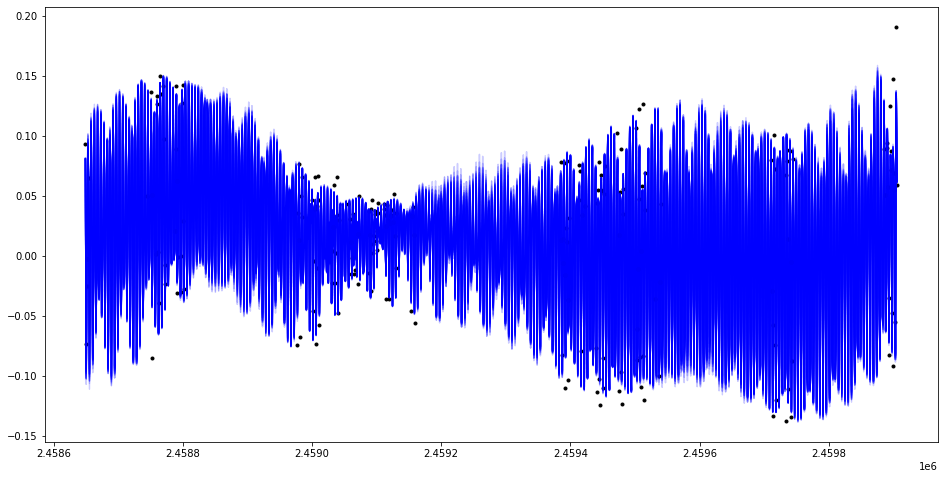

In [194]:
plt.figure(figsize=(16, 8))

plt.plot(times[:-1], eigen2vectors[1],'k.')
tplot = np.linspace(np.min(times[:-1]), np.max(times[:-1]), 1000)
 
for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.2)
plt.show()

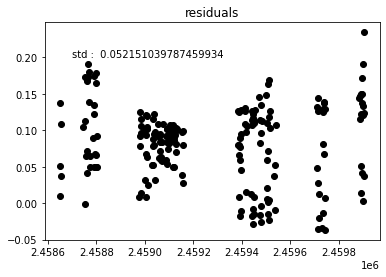

In [211]:
y_sample = Display(flat_samples[0,:], times[:-1])

residuals = eigen2vectors[1] - y_sample

plt.plot(times[:-1], residuals, 'ok')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 0.2) )
plt.title('residuals')
plt.show()

## CCF

In [7]:
B_table = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/B.txt')
times_pca = times[:-1] - 2459000
times_B = B_table[:,0]
B = B_table[:,1]
dB = B_table[:,2]

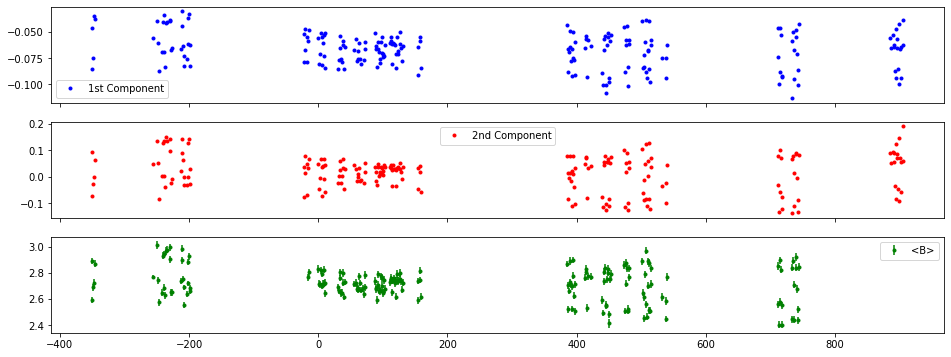

In [8]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(311)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(times_pca, eigen2vectors[1], 'r.', label='2nd Component')
plt.legend()
# make these tick labels invisible
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.legend()
plt.show()


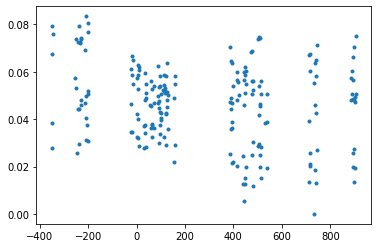

In [9]:
sig1 = eigen2vectors[0] - np.min(eigen2vectors[0])
#sig1 = sig1/np.min(sig1)

plt.plot(times_pca, sig1, '.')
plt.show()

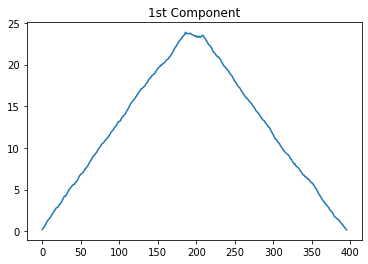

In [10]:
CCF1 = signal.correlate(B,sig1)
plt.plot(CCF1)
plt.title("1st Component")
plt.show()

In [11]:
CCF2 = signal.correlate(B,eigen2vectors[1])

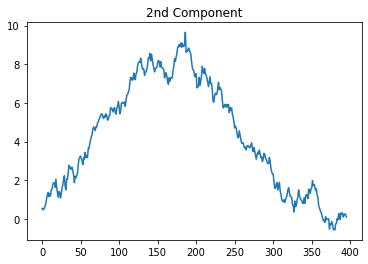

In [12]:
plt.plot(CCF2)
plt.title("2nd Component")
plt.show()

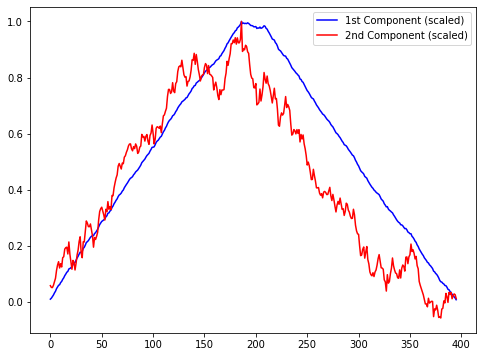

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(CCF1/np.max(CCF1), 'b', label='1st Component (scaled)')
plt.plot(CCF2/np.max(CCF2), 'r', label='2nd Component (scaled)')
plt.legend()
plt.show()